Regressions between ERA5 (dif. variables) and Cloud Index (CI) in Corrientes Argentina

Las anomalias de CI se generaron asi:

* Calculo el CI mensuales para los meses con menos del 20% de datos faltantes
* Calculo las anomalias de CI mensuales (le resto a las medias mensuales la CI climatologica de cada mes calculada sobre el periodo comun con el satelite: fecha_inicio_climatologia_str = "1983-12-15"
fecha_final_climatologia_str = "2016-11-15")
* Todo se guarda en csvs: cada columna es una estacion. En: "/pikachu/datos/nadia.testani/Doctorado/resultados/resultados2021/nubosidad/paper"
TCC_monthly_CI_SMN_anomaly.csv

ERA5 is for southamerica

In [1]:
import os
import pandas as pd 
import datetime 
import numpy as np

import iris
#from iris.analysis import MEAN
#from iris.analysis.stats import pearsonr
import iris.coord_categorisation

import scipy
from scipy.stats import theilslopes #theil-sen trends
from scipy.stats import linregress

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import iris.plot as iplt

import f_Iris
#import esmvalcore.preprocessor as ep 

In [2]:
# directories
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

#si estoy trabajando desde el servidor vegeta
ruta_a_archivos_ERA5_mensual = "/pikachu/datos/nadia.testani/Doctorado/datos/ERA5/mon/SAm" #ruta donde estan los archivos con datos de ERA5
ruta_a_archivos_CI = "/pikachu/datos/nadia.testani/Doctorado/resultados/resultados2021/nubosidad/paper"
ruta_a_resultados = "/pikachu/datos/nadia.testani/Doctorado/resultados/resultados2024" #ruta donde se guardan los resultados del analisis de nubosidad

Current working directory: /home/nadia.testani/Doctorado/DoctoradoCodigos/codigos2024


In [3]:
fecha_inicio_climatologia_str = "1983-12-15"
fecha_final_climatologia_str = "2016-11-15"

In [4]:
#Cloud Index
CI = pd.read_csv(f"{ruta_a_archivos_CI}/TCC_monthly_CI_SMN.csv") #from 1961-01-01 until 2021-11-01

#set dates as index
CI = CI.set_index(CI["Unnamed: 0"]) 
CI = CI.drop(["Unnamed: 0"], axis = 1)
CI.index = pd.DatetimeIndex(CI.index)

#estimate regional mean
CI_regional_mean = CI.mean(axis=1)

#filter theil-sen trend
def calculate_theilsen_slope(y):
    slope, intercept, _, _ = theilslopes(y, range(len(y)), alpha=0.95)
    return slope, intercept

CI_detrend = CI_regional_mean.copy()
trend = calculate_theilsen_slope(CI_detrend.values)[0] * np.arange(len(CI_detrend)) + calculate_theilsen_slope(CI_detrend.values)[1]
CI_detrend = CI_detrend - trend

#estimate climatology
CI_detrend_fechas_climatologia = CI_detrend.loc[fecha_inicio_climatologia_str:fecha_final_climatologia_str]
CI_detrend_climatologia = CI_detrend_fechas_climatologia.groupby(CI_detrend_fechas_climatologia.index.month).mean() 

#estimate anomalies
def f_serie_anomalias_mensuales(serie, serie_climatologia):
    serie_anomalia = serie.copy()
    for fecha in serie_anomalia.index:
        for mes in serie_anomalia.index.month.unique():
            if fecha.month == mes:
                serie_anomalia.loc[fecha] = serie.loc[fecha]-serie_climatologia.loc[mes]
    return serie_anomalia

CI_detrend_anom = f_serie_anomalias_mensuales(CI_detrend, CI_detrend_climatologia)

In [5]:
#ERA5
file_dir = ruta_a_archivos_ERA5_mensual
file_name = "new_data.nc"
variable_name = 't2m'
t2m = iris.load_cube(f"{file_dir}/{file_name}", variable_name) 
t2m = t2m[:,0,:,:] #select expver=1

In [6]:
#select dates common to CI and climatology dates
date_i_CI = CI_detrend_anom.index[0]
date_f_CI = CI_detrend_anom.index[-1]
fecha_inicio_climatologia_str = "1983-12-15"
fecha_final_climatologia_str = "2016-11-15"

In [7]:
t2m_CIdates = f_Iris.clip_timerange(t2m, f"{str(date_i_CI)[0:10]}/{str(date_f_CI)[0:10]}")
t2m_Climdates = f_Iris.clip_timerange(t2m, f"{str(fecha_inicio_climatologia_str)[0:10]}/{str(fecha_final_climatologia_str)[0:10]}")

#check that it is ok:
time_coord = t2m_CIdates.coord("time") 
time_axis = time_coord.units.num2date(time_coord.core_points())
#print(time_axis)

In [9]:
#detrend
t2m_CIdates_detrend = f_Iris.detrend_theil_sen_cube(t2m_CIdates, dimension='time', method='linear')
t2m_CIdates_detrend.data[:,4,5]
iris.save(t2m_CIdates_detrend, f"{ruta_a_resultados}/t2m_detrend.nc")

/home/nadia.testani/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nadia.testani/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
#anomalies 
t2m_Climdates_detrend = f_Iris.clip_timerange(t2m_CIdates_detrend, f"{str(fecha_inicio_climatologia_str)[0:10]}/{str(fecha_final_climatologia_str)[0:10]}")

#iris.coord_categorisation.add_month(t2m_CIdates_detrend, 'time', name='month')
#iris.coord_categorisation.add_month(t2m_Climdates_detrend, 'time', name='month')

monthly_means = t2m_Climdates_detrend.aggregated_by('month', iris.analysis.MEAN)

reps = (t2m_CIdates_detrend.shape[0]+1)/12  #sum 1 because the last year is not complete
clim_array = np.repeat(monthly_means.data, reps, axis=0)
clim_array = clim_array[0:t2m_CIdates_detrend.shape[0],:,:]
t2m_detrend_anoms = t2m_CIdates_detrend - clim_array
iris.save(t2m_detrend_anoms, f"{ruta_a_resultados}/t2m_detrend_anoms.nc")

In [51]:
#regression

cube = t2m_detrend_anoms
series = np.array(CI_detrend_anom)

# Extract the cube data as a NumPy array
cube_data = cube.data

# Reshape the cube data to 2D (time x space)
cube_reshaped = cube_data.reshape(cube_data.shape[0], -1)

# Perform linear regression for each grid point
regression_results = []
for point_data in cube_reshaped.T:
    slope, intercept, r_value, p_value, std_err = linregress(series, point_data)
    regression_results.append(r_value)
    #regression_results.append({
     #   'slope': slope,
     #   'intercept': intercept,
     #   'r_value': r_value,
     #   'p_value': p_value,
     #   'std_err': std_err
    #}
    

# Convert the results to a NumPy array with the same shape as the original cube
regression_array = np.array(regression_results).reshape(cube_data.shape[1:])

# Create a new Iris cube with the regression results
regression_cube = cube[1,:,:].copy(data=regression_array)


In [56]:
iris.save(regression_cube, f"{ruta_a_resultados}/t2m_CI_regression.nc")

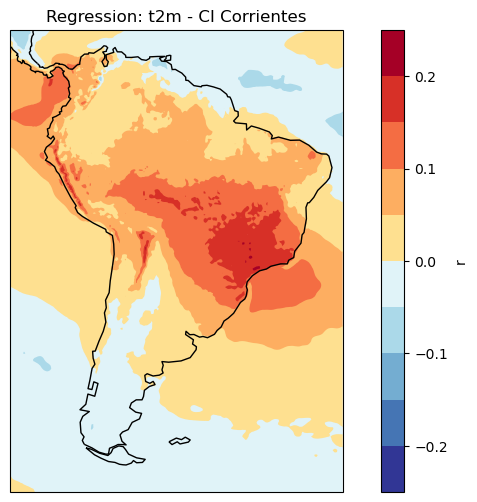

In [89]:
#plot
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap("brewer_RdYlBu_11")
iplt.contourf(regression_cube, levels=np.arange(-0.25, 0.30, 0.05), cmap=cmap.reversed()) 
plt.colorbar(label="r")
plt.title("Regression: t2m - CI Corrientes")
iplt.plt.gca().coastlines()

### Repeat the same with total precipitation (tp)


In [90]:
#ERA5
file_dir = ruta_a_archivos_ERA5_mensual
file_name = "new_data.nc"
variable_name = 'tp'
tp = iris.load_cube(f"{file_dir}/{file_name}", variable_name) 
tp = tp[:,0,:,:] #select expver=1

In [93]:
tp_CIdates = f_Iris.clip_timerange(tp, f"{str(date_i_CI)[0:10]}/{str(date_f_CI)[0:10]}")
tp_Climdates = f_Iris.clip_timerange(tp, f"{str(fecha_inicio_climatologia_str)[0:10]}/{str(fecha_final_climatologia_str)[0:10]}")

#check that it is ok:
time_coord = tp_CIdates.coord("time") 
time_axis = time_coord.units.num2date(time_coord.core_points())
#print(time_axis)

In [94]:
#detrend
tp_CIdates_detrend = f_Iris.detrend_theil_sen_cube(tp_CIdates, dimension='time', method='linear')
tp_CIdates_detrend.data[:,4,5]
iris.save(tp_CIdates_detrend, f"{ruta_a_resultados}/tp_detrend.nc")

/home/nadia.testani/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nadia.testani/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [99]:
#anomalies 
tp_Climdates_detrend = f_Iris.clip_timerange(tp_CIdates_detrend, f"{str(fecha_inicio_climatologia_str)[0:10]}/{str(fecha_final_climatologia_str)[0:10]}")

iris.coord_categorisation.add_month(tp_CIdates_detrend, 'time', name='month')
iris.coord_categorisation.add_month(tp_Climdates_detrend, 'time', name='month')

monthly_means = tp_Climdates_detrend.aggregated_by('month', iris.analysis.MEAN)

reps = (tp_CIdates_detrend.shape[0]+1)/12  #sum 1 because the last year is not complete
clim_array = np.repeat(monthly_means.data, reps, axis=0)
clim_array = clim_array[0:tp_CIdates_detrend.shape[0],:,:]
tp_detrend_anoms = tp_CIdates_detrend - clim_array
iris.save(tp_detrend_anoms, f"{ruta_a_resultados}/tp_detrend_anoms.nc")

In [100]:
#regression

cube = tp_detrend_anoms
series = np.array(CI_detrend_anom)

# Extract the cube data as a NumPy array
cube_data = cube.data

# Reshape the cube data to 2D (time x space)
cube_reshaped = cube_data.reshape(cube_data.shape[0], -1)

# Perform linear regression for each grid point
regression_results = []
for point_data in cube_reshaped.T:
    slope, intercept, r_value, p_value, std_err = linregress(series, point_data)
    regression_results.append(r_value)
    #regression_results.append({
     #   'slope': slope,
     #   'intercept': intercept,
     #   'r_value': r_value,
     #   'p_value': p_value,
     #   'std_err': std_err
    #}
    

# Convert the results to a NumPy array with the same shape as the original cube
regression_array = np.array(regression_results).reshape(cube_data.shape[1:])

# Create a new Iris cube with the regression results
regression_cube = cube[1,:,:].copy(data=regression_array)

iris.save(regression_cube, f"{ruta_a_resultados}/tp_CI_regression.nc")

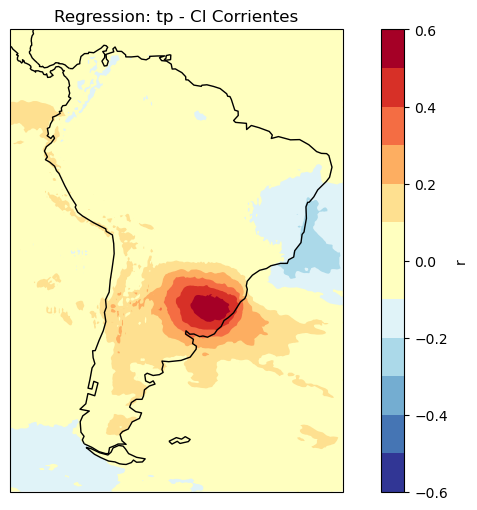

In [104]:
#plot
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap("brewer_RdYlBu_11")
iplt.contourf(regression_cube, levels=np.arange(-0.60, 0.70, 0.1), cmap=cmap.reversed()) 
plt.colorbar(label="r")
plt.title("Regression: tp - CI Corrientes")
iplt.plt.gca().coastlines()